## Аналитика поведения пользователей мобильного приложения 

Исследование проводится для стартапа, который продаёт продукты питания. 

Исходные данные:

- название события;
- уникальный идентификатор пользователя;
- время события;
- номер эксперимента и контрольных групп

Цель исследования: проанализировать, как ведут себя пользователи мобильного приложения, изучив воронку продаж и результаты A/A/B-эксперимента после замены шрифта в приложении.

## Подготовка и предобработка данных

In [1]:
#Загрузим библиотеки, которые понадобятся
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns 
from numpy import median
from scipy import stats as st
import datetime as dt
from datetime import timedelta


import warnings
warnings.filterwarnings('ignore')

In [2]:
import plotly.io as pio
pio.renderers.default='notebook'

In [3]:
# Настройки для графиков
sns.set(font_scale=1.3)
sns.set_style('whitegrid',
              {'figure.facecolor': '0.95',
               'figure.facecolor': 'white',
               'font.family': ['Liberation Serif']})

plt.rcParams["font.family"] = "Liberation Serif", "Garamond", "serif"

my_colors =  ['rgb(146, 123, 21)', 'rgb(206, 206, 40)', 'rgb(175, 51, 21)', 'rgb(35, 36, 21)', 'rgb(24, 87, 149)', 'rgb(4, 41, 89)']

In [4]:
# Прочитаем файл hypothesis и сохраним его
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('logs_exp.csv', sep='\t')
logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [5]:
# Заменим названия столбцов
logs = logs.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_datetime', 'ExpId': 'group'})

In [6]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name        244126 non-null object
user_id           244126 non-null int64
event_datetime    244126 non-null int64
group             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [7]:
# Приведем event_datetime к типу datetime
logs['event_datetime'] = pd.to_datetime(logs.event_datetime, unit="s")
logs.head(5)

,event_name,user_id,event_datetime,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [8]:
# Проверка на нулевые значения
logs.isnull().sum()

event_name        0
user_id           0
event_datetime    0
group             0
dtype: int64

Нулевых значений не выявлено. Проверим, сколько уникальных group содержится в датасете.

In [9]:
# Уникальные номера group
logs['group'].value_counts()

248    85747
246    80304
247    78075
Name: group, dtype: int64

Дополнительных групп, кроме ожидаемых, нет. Проверим строки на дубликаты.

In [10]:
print('Количество дубликатов:', logs.duplicated().sum())

Количество дубликатов: 413


Обнаружены дубликаты, их можно удалить.

In [11]:
# Удаление дубликатов
logs = logs.drop_duplicates()
print('Количество дубликатов:', logs.duplicated().sum())

Количество дубликатов: 0


Добавим столбец дат

In [12]:
logs['date'] = logs['event_datetime'].dt.date
logs['date'] = pd.to_datetime(logs['date'])
logs.head(5)

,event_name,user_id,event_datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Вывод

Данные обработаны, пропущенных значений не выявлено, изменены названия столбцов, тип данных приведен к нужному. Удалены дубликаты. Добавлен столбец с датами.

## Изучение данных

Посмотрим, сколько всего событий и уникальных пользователей в логе.

In [13]:
# Уникальные event_name
logs['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [14]:
# Количество записей
logs_before = logs.shape[0]
print('Всего записей в log —', logs_before)

Всего записей в log — 243713


In [15]:
# Уникальные пользователи
users_before = logs['user_id'].nunique()
print('Уникальных пользователей в log —', users_before)

Уникальных пользователей в log — 7551


In [16]:
# События на 1 пользователя в среднем
print('В среднем, на пользователя приходится', int(logs_before / users_before), 'события')

В среднем, на пользователя приходится 32 события


Посмотрим максимальная и минимальная дата в датафрейме

In [17]:
print('Минимальная дата —', logs['event_datetime'].min())
print('Максимальная дата —', logs['event_datetime'].max())

Минимальная дата — 2019-07-25 04:43:36
Максимальная дата — 2019-08-07 21:15:17


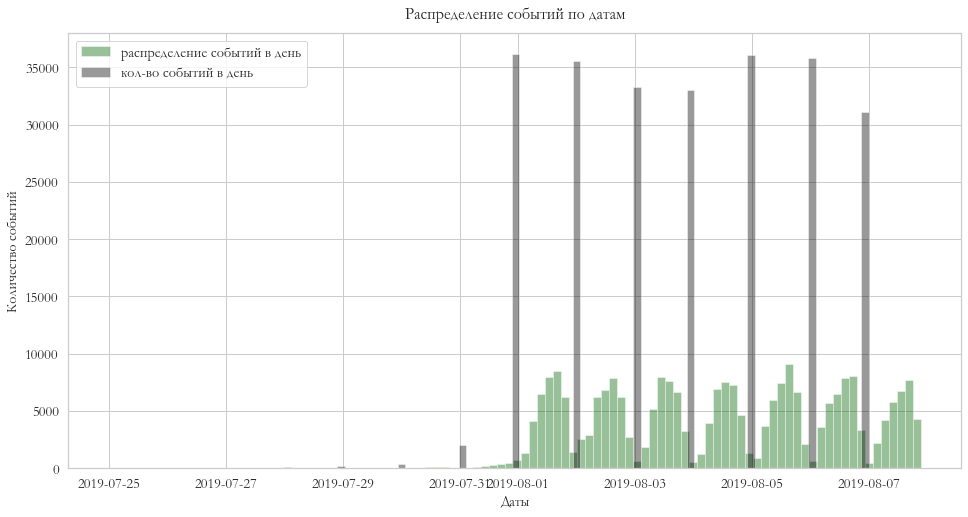

In [18]:
# Построим гистрограмму 
plt.figure(figsize=(16, 8))
ax = sns.distplot(logs['event_datetime'], kde=False, bins=100, color='darkgreen', label='распределение событий в день') 
ax = sns.distplot(logs['date'], kde=False, bins=100, color='black', label='кол-во событий в день') 
ax.set_title("Распределение событий по датам", fontsize=16, pad = 15)
ax.set_xlabel("Даты", fontsize=14)
ax.set_ylabel("Количество событий", fontsize=14)
plt.legend()
plt.show()

По гистрограмме можно определить, что полные данные начинаются только с 01.08.2019. В данные до этого момента, вероятно, попали по некоторым пользователям предыдущие события. Отбросим даты до 01.08.2019 и будем рассматривать только полные данные за неделю до 07.08.2019.

In [19]:
# Данные с 2019-08-01
logs_date = logs[logs['date'] >= '2019-08-01']
display(logs_date.head(5))
logs_after = logs_date.shape[0]
print('Всего записей в logs_date —', logs_after)

,event_name,user_id,event_datetime,group,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


Всего записей в logs_date — 240887


In [20]:
# Отбросили записей
print('Отбросили записей —', abs(logs_after - logs_before))

Отбросили записей — 2826


In [21]:
# Уникальные пользователи после
users_after = logs_date['user_id'].nunique()
print('Уникальных пользователей в log —', users_after)

Уникальных пользователей в log — 7534


In [22]:
# Отбросили пользователей
print('Отбросили пользователей —', abs(users_after - users_before))

Отбросили пользователей — 17


In [23]:
# Относительное значение удаленных строк
print('Относительное значение удаленных пользователей — {:.2%}'.format(abs(users_after - users_before) / users_before))
print('Относительное значение удаленных записей — {:.2%}'.format(abs(logs_after - logs_before) / logs_before))

Относительное значение удаленных пользователей — 0.23%
Относительное значение удаленных записей — 1.16%


Количество отброшенных строи и пользователей не так велико (около 1% записей и менее 1% пользователей). Проверим, что пользователи всех групп остались.

In [24]:
# Уникальные group
logs_date['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

Записи по пользователям всех групп остались.

### Вывод 

Определена дата, начиная с которой данные полные (01.08.2019), отброшены более старые данные. Количество потерянных записей и пользователей не значительно для дальнейшего анализа.

## Изучение воронки событий

Посмотрим, какие события есть в логах и как часто они встречаются. 


In [25]:
# Сгруппируем по событиям
logs_date_event_gr = logs_date.pivot_table(index=['event_name'], values='user_id', aggfunc='count')
logs_date_event_gr = logs_date_event_gr.sort_values(by='user_id', ascending = False)
logs_date_event_gr = logs_date_event_gr.rename(columns = {'user_id':'count_events'})
logs_date_event_gr['frequency'] = logs_date_event_gr['count_events']/logs_date_event_gr['count_events'].sum()
logs_date_event_gr = logs_date_event_gr.reset_index()
logs_date_event_gr.style.format({('frequency'):'{:.1%}'})

,event_name,count_events,frequency
0,MainScreenAppear,117328,48.7%
1,OffersScreenAppear,46333,19.2%
2,CartScreenAppear,42303,17.6%
3,PaymentScreenSuccessful,33918,14.1%
4,Tutorial,1005,0.4%


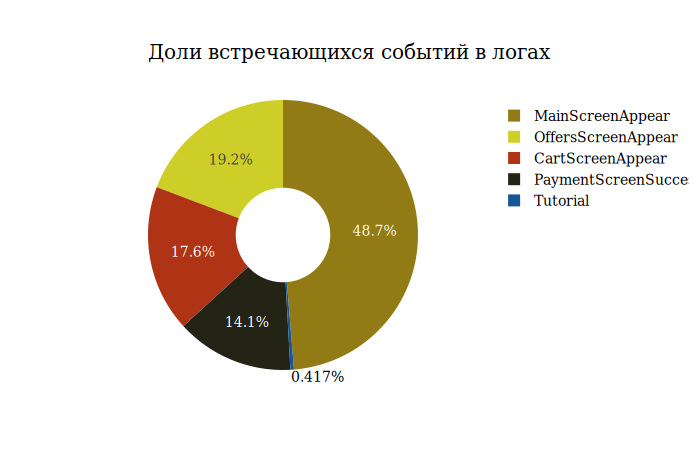

In [65]:
# Построим график частоты встречающихся событий

fig = go.Figure(data=[go.Pie(labels=logs_date_event_gr['event_name'], values=logs_date_event_gr['frequency'],  
                             hole=0.35, marker_colors=my_colors)])
fig.update_layout(
    title={
        'text': "Доли встречающихся событий в логах",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="X Axis Title",
    yaxis_title="Y Axis Title",
    font=dict(
        family="serif",
        size=14,
        color="black"))
fig.show("svg")

Чаще всего встречается событие MainScreenAppear	 - почти 50% от всех. Реже всего - Tutorial, менее 1%. Остальные события распределены примерно равномерно от 19% до 14%.

Посчитаем, сколько пользователей совершали каждое из этих событий.
Отсортируем события по числу пользователей. 

In [27]:
# Сгруппируем по событиям и уникальным пользователям 
logs_date_event_gr_user = logs_date.pivot_table(index=['event_name'], values = 'user_id', aggfunc='nunique')
logs_date_event_gr_user = logs_date_event_gr_user.sort_values(by='user_id', ascending = False)
logs_date_event_gr_user = logs_date_event_gr_user.rename(columns = {'user_id':'unique_count_events', 'event_name':'name'}).reset_index()
logs_date_event_gr_user['conversion'] = logs_date_event_gr_user['unique_count_events']/logs_date['user_id'].nunique()
logs_date_event_gr_user['conversion'] = round(logs_date_event_gr_user['conversion'], 2)
logs_date_event_gr_user[['event_name','unique_count_events', 'conversion']].style.format({('conversion'):'{:.1%}'})

,event_name,unique_count_events,conversion
0,MainScreenAppear,7419,98.0%
1,OffersScreenAppear,4593,61.0%
2,CartScreenAppear,3734,50.0%
3,PaymentScreenSuccessful,3539,47.0%
4,Tutorial,840,11.0%


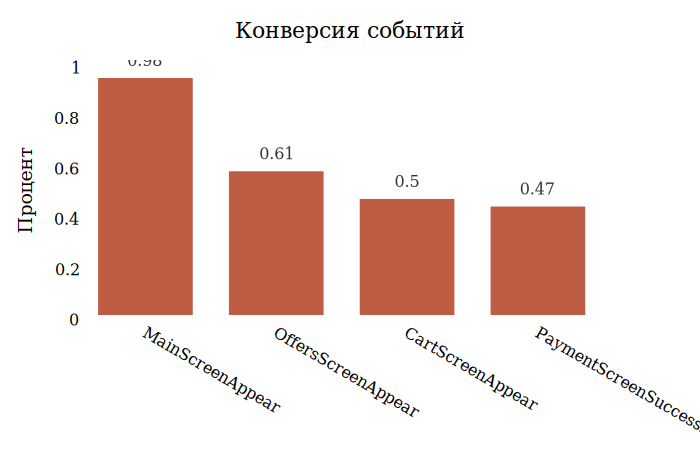

In [66]:
# Построим график частоты встречающихся событий для уникальных пользователей 

fig = px.bar(logs_date_event_gr_user, x='event_name', y='conversion',  text='conversion', height=500, width=1000)
#fig.update_xaxes(tickangle=-15)  
fig.update_layout(plot_bgcolor='white')
fig.update_layout(
    title={
        'text': "Конверсия событий",
        'y':0.95,
        'x':0.5,
        'xanchor': 'auto',
        'yanchor': 'top'},
    xaxis_title="",
    yaxis_title="Процент",
    font=dict(
        family="Garamond",
        size=16,
        color="black"))
fig.update_traces(textposition="outside", selector=dict(type='bar'), 
                  marker_color='rgb(175, 51, 21)', marker_line_color='white',
                  marker_line_width=10, opacity=0.8)

fig.show("svg")

Предположительно, события выстраиваются в следующем порядке: 
- MainScreenAppear, 
- OffersScreenAppear, 
- CartScreenAppear,
- PaymentScreenSuccessful. 

Событие Tutorial, вероятно, является необязательным для покупки, всего 11% пользователей им воспользовались. Для расчета воронки его можно не учитывать. 

Посмотрим воронку событий, какая доля пользователей переходит на следующий шаг. Нужно по каждому пользователю посчитать, в какое время он впервые совершил определённое событие. Затем найти тех, чьи события происходили в нужном порядке.

In [29]:
# Для пользователей посчитаем время каждого первого события
users = logs_date.pivot_table(index='user_id', columns='event_name', values='event_datetime', aggfunc='min')
users.fillna("")

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
6888746892508752,,2019-08-06 14:06:34,,,
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,
7435777799948366,,2019-08-05 08:06:34,,,
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,
...,...,...,...,...,...
9217594193087726423,2019-08-02 09:00:58,,2019-08-02 09:01:08,2019-08-02 09:00:57,
9219463515465815368,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16,
9220879493065341500,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,,


In [30]:
# Шаги воронки MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

# Прошли Tutorial и оплатили 
tut_and_pay = step_4 & (users['Tutorial'])

# Всего смотрели Tutorial 
tut_all = ~users['Tutorial'].isna()

# Количество пользователей по шагам 
main_screen = users[step_1].shape[0]
offers_screen = users[step_2].shape[0]
cart_screen = users[step_3].shape[0]
success_payment = users[step_4].shape[0]

steps = ['Просмотр страницы main', 'Просмотр страницы offers', 'Просмотр страницы cart', 'Оплатили']
count = [main_screen, offers_screen, cart_screen, success_payment]

print(steps[0], main_screen)
print(steps[1], offers_screen)
print(steps[2], cart_screen)
print(steps[3], success_payment)


Просмотр страницы main 7419
Просмотр страницы offers 4201
Просмотр страницы cart 1767
Оплатили 454


In [31]:
print('Просмотрели Tutorial и оплатили', users[tut_and_pay].shape[0])
print('Просмотрели Tutorial всего', users[tut_all].shape[0])

Просмотрели Tutorial и оплатили 220
Просмотрели Tutorial всего 840


Примерно каждый четвертый, кто просматривал Tutorial в итоге произвел оплату.

Построим воронку событий.

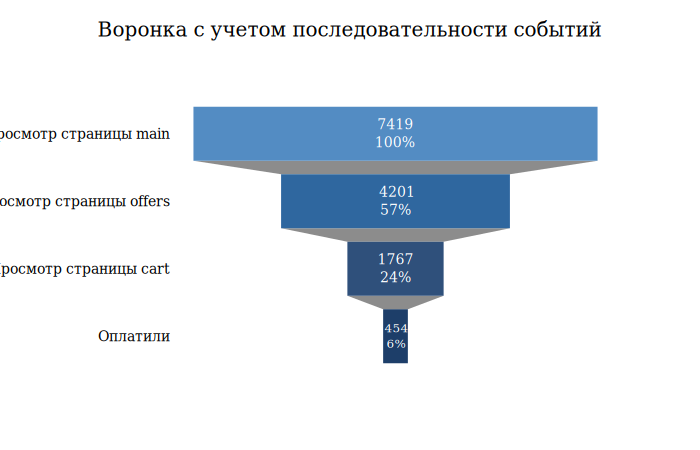

In [67]:
fig=go.Figure(go.Funnel(y=steps, x=count, textposition = "inside", textinfo = "value+percent initial",
    opacity = 0.9, marker = {"color": ['rgb(64, 127, 189)','rgb(24, 87, 149)', 'rgb(24, 61, 109)', 'rgb(4, 41, 89)']}))
fig.update_layout(
    title={
        'text': "Воронка с учетом последовательности событий",
        'y':0.95,
        'x':0.5,
        'xanchor': 'auto',
        'yanchor': 'top'},
    font=dict(
        family="serif",
        size=14,
        color="black"))
fig.update_layout(plot_bgcolor='white')
fig.show("svg")

Всего 6% пользователей совершают оплату из всех, кто просмотрел главную страницу при движении Просмотр страницы main -> Просмотр страницы offers -> Просмотр страницы cart -> Оплатили

Посмотрим, какой отсев на каждом шаге.

In [33]:
# Посмотрим, какая доля пользователей проходит на следующий шаг воронки от числа пользователей на предыдущем
funnel = pd.DataFrame(count, steps).reset_index()
funnel['pct_go_away'] = abs(funnel[0].pct_change(axis=0))
funnel = funnel.rename({0: 'users_per_steps', 'index': 'step_name'}, axis='columns')
funnel.style.format({('pct_go_away'):'{:.1%}'})

,step_name,users_per_steps,pct_go_away
0,Просмотр страницы main,7419,nan%
1,Просмотр страницы offers,4201,43.4%
2,Просмотр страницы cart,1767,57.9%
3,Оплатили,454,74.3%


Больше всего пользователей в процентном отношении отсеялось на последнем шаге (74%) между событиями Просмотр страницы cart (CartScreenAppear) и Оплатили (PaymentScreenSuccessful), требуется проверка платежного окна.

Посмотрим, сколько времени чаще всего требуется от начала работы до использования Tutorial. Сгруппируем по пользователям таблицу, оставив только тех пользователей, кто пользовался Tutorial. 

In [34]:
gr_user_tut = logs_date.pivot_table(index=['user_id'], columns = 'event_name', values = 'event_datetime', aggfunc='min')
gr_user_tut.dropna(subset = ['Tutorial'], inplace = True) 
gr_user_tut.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
9841258664663090,2019-08-03 10:52:15,2019-08-03 10:47:59,2019-08-03 10:49:42,2019-08-03 17:57:27,2019-08-03 10:47:28
29094035245869447,2019-08-02 13:15:22,2019-08-02 13:13:24,2019-08-02 13:13:43,2019-08-02 15:23:05,2019-08-02 13:13:20
41866159597273689,NaT,2019-08-03 13:31:36,2019-08-04 14:56:47,NaT,2019-08-03 13:31:03
51078901260117593,NaT,2019-08-04 05:22:29,NaT,NaT,2019-08-04 05:34:44
65731010663501604,NaT,2019-08-03 11:07:32,NaT,NaT,2019-08-03 11:07:34


In [35]:
gr_user_tut['timedel_main'] = (gr_user_tut['MainScreenAppear'] - gr_user_tut['Tutorial']) / np.timedelta64(1, 's')
print('Медианное время от MainScreen до Tutorial, сек - ', gr_user_tut['timedel_main'].median())

Медианное время от MainScreen до Tutorial, сек -  30.0


In [36]:
gr_user_tut['timedel_offer'] = (gr_user_tut['OffersScreenAppear'] - gr_user_tut['Tutorial']) / np.timedelta64(1, 's')
print('Медианное время от OffersScreen до Tutorial, сек - ', gr_user_tut['timedel_offer'].median())

Медианное время от OffersScreen до Tutorial, сек -  90.0


In [37]:
gr_user_tut['timedel_cart'] = (gr_user_tut['CartScreenAppear'] - gr_user_tut['Tutorial']) / np.timedelta64(1, 's')
print('Медианное время от CartScreen до Tutorial, сек - ', gr_user_tut['timedel_cart'].median())

Медианное время от CartScreen до Tutorial, сек -  153.0


In [38]:
gr_user_tut['timedel_pay'] = (gr_user_tut['PaymentScreenSuccessful'] - gr_user_tut['Tutorial']) / np.timedelta64(1, 's')
print('Медианное время от PaymentScreen до Tutorial, сек - ', gr_user_tut['timedel_pay'].median())

Медианное время от PaymentScreen до Tutorial, сек -  552.0


In [39]:
gr_user_tut.head(5)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,timedel_main,timedel_offer,timedel_cart,timedel_pay
user_id,,,,,,,,,
9841258664663090,2019-08-03 10:52:15,2019-08-03 10:47:59,2019-08-03 10:49:42,2019-08-03 17:57:27,2019-08-03 10:47:28,31.0,134.0,287.0,25799.0
29094035245869447,2019-08-02 13:15:22,2019-08-02 13:13:24,2019-08-02 13:13:43,2019-08-02 15:23:05,2019-08-02 13:13:20,4.0,23.0,122.0,7785.0
41866159597273689,NaT,2019-08-03 13:31:36,2019-08-04 14:56:47,NaT,2019-08-03 13:31:03,33.0,91544.0,NaN,NaN
51078901260117593,NaT,2019-08-04 05:22:29,NaT,NaT,2019-08-04 05:34:44,-735.0,NaN,NaN,NaN
65731010663501604,NaT,2019-08-03 11:07:32,NaT,NaT,2019-08-03 11:07:34,-2.0,NaN,NaN,NaN


Разброс до первого просмотра Tutorial широкий, иногда пользователи смотрят справочный раздел и только после — другие страницы. Однозначеные выводы о типе поведения пользователей при просмотре этого раздела сделать сложно, по медианным значениям наименьшее время между просмотром MainScreen и Tutorial — 30 секунд. 

Построим воронку без учета последовательности событий, чтобы учесть все возможные пути. В logs_date_event_gr_user посчитана общая конверсия.

In [40]:
# Посмотрим, какая доля пользователей проходит на следующий шаг воронки от числа пользователей на предыдущем в pct_go_away
logs_date_event_gr_user = logs_date_event_gr_user.iloc[:4] 
logs_date_event_gr_user['conversion'] = logs_date_event_gr_user['conversion'].round(2)
logs_date_event_gr_user['pct_go_away'] = abs(logs_date_event_gr_user['conversion'].pct_change(axis=0))
logs_date_event_gr_user.style.format({('pct_go_away'):'{:.1%}'})

,event_name,name,unique_count_events,conversion,pct_go_away
0,MainScreenAppear,1,7419,0.98,nan%
1,OffersScreenAppear,1,4593,0.61,37.8%
2,CartScreenAppear,1,3734,0.5,18.0%
3,PaymentScreenSuccessful,1,3539,0.47,6.0%


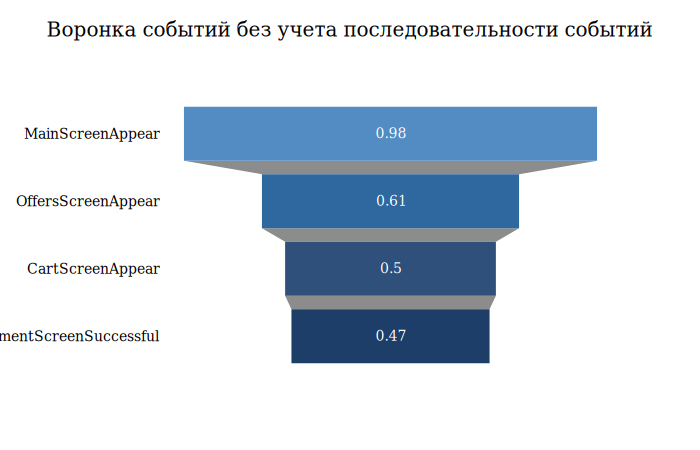

In [68]:
fig=go.Figure(go.Funnel(y=logs_date_event_gr_user['event_name'], x=logs_date_event_gr_user['conversion'], textposition = "inside", textinfo = "value",
    opacity = 0.9, marker = {"color": ['rgb(64, 127, 189)','rgb(24, 87, 149)', 'rgb(24, 61, 109)', 'rgb(4, 41, 89)']}))
fig.update_layout(
    title={
        'text': "Воронка событий без учета последовательности событий",
        'y':0.95,
        'x':0.5,
        'xanchor': 'auto',
        'yanchor': 'top'},
    font=dict(
        family="serif",
        size=14,
        color="black"))
fig.update_layout(plot_bgcolor='white')
fig.show("svg")

Больше всего клиентов отсеивается между MainScreenAppear и OffersScreenAppear, 38%. Почти половина клиентов делает заказ.

Исследуем конверсию по группам.

In [42]:
# Сгруппируем по событиям и группам
logs_date_event_gr_user_3 = logs_date.pivot_table(index=['event_name'], columns='group', values = 'user_id', aggfunc='nunique')
logs_date_event_gr_user_3 = logs_date_event_gr_user_3.sort_values(by=246, ascending = False)

logs_date_event_gr_user_3['conversion_246'] = logs_date_event_gr_user_3[246]/logs_date.query('group == 246')['user_id'].nunique()
logs_date_event_gr_user_3['conversion_247'] = logs_date_event_gr_user_3[246]/logs_date.query('group == 247')['user_id'].nunique()
logs_date_event_gr_user_3['conversion_248'] = logs_date_event_gr_user_3[246]/logs_date.query('group == 248')['user_id'].nunique()

logs_date_event_gr_user_3[['conversion_246', 'conversion_247', 'conversion_248']].style.format({('conversion_246'):'{:.1%}', ('conversion_247'):'{:.1%}', ('conversion_248'):'{:.1%}'})

group,conversion_246,conversion_247,conversion_248
event_name,,,
MainScreenAppear,98.6%,97.5%,96.6%
OffersScreenAppear,62.1%,61.4%,60.8%
CartScreenAppear,51.0%,50.4%,49.9%
PaymentScreenSuccessful,48.3%,47.8%,47.3%
Tutorial,11.2%,11.1%,11.0%


In [43]:
logs_date_event_gr_user_3 = logs_date_event_gr_user_3.iloc[:4][['conversion_246', 'conversion_247', 'conversion_248']].round(2)

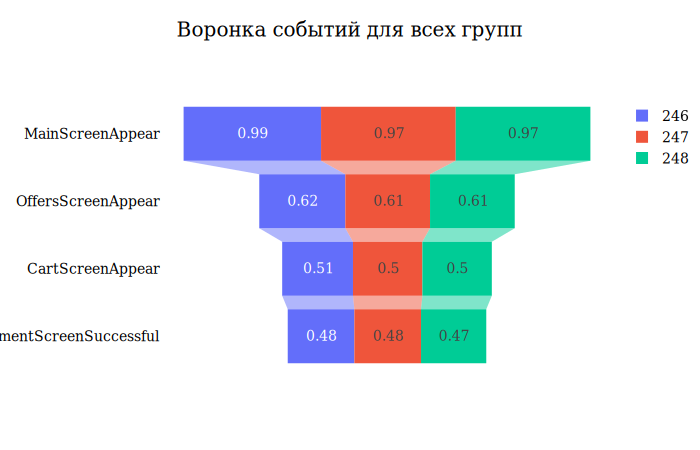

In [69]:
# Построим график воронки для всех групп
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = logs_date_event_gr_user_3.index,
    x = logs_date_event_gr_user_3['conversion_246'],
    textinfo = "value"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = logs_date_event_gr_user_3.index,
    x = logs_date_event_gr_user_3['conversion_247'],
    textposition = "inside",
    textinfo = "value"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = logs_date_event_gr_user_3.index,
    x = logs_date_event_gr_user_3['conversion_248'],
    textposition = "inside",
    textinfo = "value"))
fig.update_layout(
    title={
        'text': "Воронка событий для всех групп",
        'y':0.95,
        'x':0.5,
        'xanchor': 'auto',
        'yanchor': 'top'},
    font=dict(
        family="serif",
        size=14,
        color="black"))
fig.update_layout(plot_bgcolor='white')
fig.show("svg")

По всем группам конверсия согласуется. Посмотрим, значимы ли различия в последующих статистических тестах.

### Вывод 

Примерно 48% пользователей совершают оплату из всех, кто просмотрел главную страницу. 

Больше всего пользователей в процентном отношении отсеялось между событиями MainScreenAppear и OffersScreenAppear (38%).

Примерно каждый четвертый, кто просматривал Tutorial в итоге произвел оплату. Если Tutorial открывают, то чаще всего это делают после просмотра MainScreen.

## Изучение результатов эксперимента

Проверим, сколько пользователей осталось в каждой группе.

In [45]:
print('Пользователей в группе 248 —', logs_date.query('group == "248"')['user_id'].nunique())
print('Пользователей в группе 247 —', logs_date.query('group == "247"')['user_id'].nunique())
print('Пользователей в группе 246 —', logs_date.query('group == "246"')['user_id'].nunique())

Пользователей в группе 248 — 2537
Пользователей в группе 247 — 2513
Пользователей в группе 246 — 2484


**А/А тестирование**

Есть 2 контрольные группы для А/А-эксперимента (246 и 247).

Применим статистический Z-тест о равенстве долей разницу между выборками 246 и 247, чтобы обеспечить дальнейшую корректность расчетов. Z-тест проверяет равество пропорции в выборке.

*Нулевая гипотеза: По группам 246 и 247 нет оснований считать отличие конверсий статистически достоверным*

*Альтернативная гипотеза: Конверсия группы 246 статистически значимо отличается от конверсии группы 247*

Критический уровень статистической значимости примем за 5%, что означает, что мы допускаем 5% вероятность ошибки в полученном результате.
При значениях p-value менее 0,05 следует признать, что можем отвергнуть нулевую гипотезу.

Поскольку требуется провести несколько тестов (а именно 16), то следует применить поправку для множественных сравнений. 
По методу Бонферрони, уровень значимости будет равен 0,05/16=0,003. Согласно методу Шидака уровень значимости также равен 0,003.
Примем его за базовое значение.

Самое популярное событие, как показано в предыдущем этапе, — MainScreenAppear. 
Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп 246 и 247

In [46]:
# Напишем функцию для проверки гипотезы по критерию о равенстве долей 
def z_value_func(data, event, group_1, group_2):
    
    # всего пользователей по событию в первой группе:
    user_gr_1 = data.query('group == @group_1 & event_name == @event')['user_id'].nunique()
    
    # всего пользователей в первой группе:
    all_users_gr1 = data.query('group == @group_1')['user_id'].nunique()
    
    # пропорция успехов в первой группе:
    p1 = user_gr_1 / all_users_gr1
    print('Пользователей в группе', group_1, 'по событию', event, '—', user_gr_1)
    print('Доля пользователей в группе', group_1, 'по событию', event, '—', round(p1, 3))
    
    # всего пользователей по событию во второй группе:
    user_gr_2 = data.query('group == @group_2 & event_name == @event')['user_id'].nunique()
    
    # всего пользователей во второй группе:
    all_users_gr2 = data.query('group == @group_2')['user_id'].nunique()
    
    # пропорция успехов во второй группе:
    p2 = user_gr_2 / all_users_gr2
    print('Пользователей в группе', group_2, 'по событию', event, '—', user_gr_2)
    print('Доля пользователей в группе', group_2, 'по событию', event, '—', round(p2, 3))    
    
    alpha = .003 # критический уровень статистической значимости

    successes = np.array([user_gr_1, user_gr_2])
    all_users = np.array([all_users_gr1, all_users_gr2])

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (all_users[0] + all_users[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2 
 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / all_users[0] + 1 / all_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print()
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным') 


In [47]:
# статистический Z-тест о равенстве долей разницу между выборками 246 и 247 для события MainScreenAppear
z_value_func(logs_date, 'MainScreenAppear', '246', '247')

Пользователей в группе 246 по событию MainScreenAppear — 2450
Доля пользователей в группе 246 по событию MainScreenAppear — 0.986
Пользователей в группе 247 по событию MainScreenAppear — 2476
Доля пользователей в группе 247 по событию MainScreenAppear — 0.985

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


По самому популярному событию MainScreenAppear нет оснований считать отличие между группами достоверным. Проведем тот же тест для остальных событий. 

In [48]:
# статистический Z-тест о равенстве долей разницу между выборками 246 и 247 для события OffersScreenAppear
z_value_func(logs_date, 'OffersScreenAppear', '246', '247')

Пользователей в группе 246 по событию OffersScreenAppear — 1542
Доля пользователей в группе 246 по событию OffersScreenAppear — 0.621
Пользователей в группе 247 по событию OffersScreenAppear — 1520
Доля пользователей в группе 247 по событию OffersScreenAppear — 0.605

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


In [49]:
# статистический Z-тест о равенстве долей разницу между выборками 246 и 247 для события CartScreenAppear
z_value_func(logs_date, 'CartScreenAppear', '246', '247')

Пользователей в группе 246 по событию CartScreenAppear — 1266
Доля пользователей в группе 246 по событию CartScreenAppear — 0.51
Пользователей в группе 247 по событию CartScreenAppear — 1238
Доля пользователей в группе 247 по событию CartScreenAppear — 0.493

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


In [50]:
# статистический Z-тест о равенстве долей разницу между выборками 246 и 247 для события PaymentScreenSuccessful
z_value_func(logs_date, 'PaymentScreenSuccessful', '246', '247')

Пользователей в группе 246 по событию PaymentScreenSuccessful — 1200
Доля пользователей в группе 246 по событию PaymentScreenSuccessful — 0.483
Пользователей в группе 247 по событию PaymentScreenSuccessful — 1158
Доля пользователей в группе 247 по событию PaymentScreenSuccessful — 0.461

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


Разбиение на группы проведено корректно, тесты для всех событий по группам 246 и 247 показывают, что нет оснований считать отличие между группами А/А статистически значимым. 

**А/А/В тестирование**

Сравним группы 246 и 247  поочередно с группой 248, в которой был изменен шрифт (группа В)
Посмотрим результаты по каждой из контрольных групп в отдельности по каждому событию и с объединённой контрольной группой.

- Применим статистический Z-тест о равенстве долей разницу между выборками 246 и 248.

*Нулевая гипотеза 1: По группам 246 и 248 нет оснований считать отличие конверсий статистически достоверным*

*Альтернативная гипотеза 1: Конверсия группы 246 статистически значимо отличается от конверсии группы 248*


- Применим статистический Z-тест о равенстве долей разницу между выборками 247 и 248.

*Нулевая гипотеза 1: По группам 247 и 248 нет оснований считать отличие конверсий статистически достоверным*

*Альтернативная гипотеза 1: Конверсия группы 247 статистически значимо отличается от конверсии группы 248*


- Применим статистический Z-тест о равенстве долей разницу между выборками 249 и 248, где группа 249 — совокупность групп 246 и 247.

*Нулевая гипотеза 1: По группам 249 и 248 нет оснований считать отличие конверсий статистически достоверным*

*Альтернативная гипотеза 1: Конверсия группы 249 статистически значимо отличается от конверсии группы 248*



In [51]:
# статистический Z-тест о равенстве долей разницу между выборками 246 и 248 для события MainScreenAppear
z_value_func(logs_date, 'MainScreenAppear', '246', '248')

Пользователей в группе 246 по событию MainScreenAppear — 2450
Доля пользователей в группе 246 по событию MainScreenAppear — 0.986
Пользователей в группе 248 по событию MainScreenAppear — 2493
Доля пользователей в группе 248 по событию MainScreenAppear — 0.983

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


In [52]:
# статистический Z-тест о равенстве долей разницу между выборками 247 и 248 для события MainScreenAppear
z_value_func(logs_date, 'MainScreenAppear', '247', '248')

Пользователей в группе 247 по событию MainScreenAppear — 2476
Доля пользователей в группе 247 по событию MainScreenAppear — 0.985
Пользователей в группе 248 по событию MainScreenAppear — 2493
Доля пользователей в группе 248 по событию MainScreenAppear — 0.983

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


По событию MainScreenAppear нет оснований считать, что группы 246 и 248, а также 246 и 247 отличаются между собой.

Сравнили результаты с каждой из контрольных групп в отдельности по каждому событию. Теперь сравним результаты с объединённой контрольной группой. Объединенная группа 249 будет состоять из суммы А-групп 246 и 247.

In [53]:
# Копия датасета
logs_date_union = logs_date.copy()

# Заменим группы 247 и 246 на 249:
logs_date_union.loc[logs_date_union['group']==246, 'group'] = 249
logs_date_union.loc[logs_date_union['group']==247, 'group'] = 249
logs_date_union.head()

,event_name,user_id,event_datetime,group,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,249,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,249,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,249,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,249,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,249,2019-08-01


In [54]:
# статистический Z-тест о равенстве долей разницу между выборками 249 (объединенные 246 и 247)
# и 248 для события MainScreenAppear
z_value_func(logs_date_union, 'MainScreenAppear', '249', '248')

Пользователей в группе 249 по событию MainScreenAppear — 4926
Доля пользователей в группе 249 по событию MainScreenAppear — 0.986
Пользователей в группе 248 по событию MainScreenAppear — 2493
Доля пользователей в группе 248 по событию MainScreenAppear — 0.983

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


По событию MainScreenAppear нет оснований считать, что группы отличаются между собой, как по отдельности, так и при объединеннии контрольной группы.

In [55]:
# статистический Z-тест о равенстве долей разницу между выборками 246 и 248 для события OffersScreenAppear
z_value_func(logs_date, 'OffersScreenAppear', '246', '248')

Пользователей в группе 246 по событию OffersScreenAppear — 1542
Доля пользователей в группе 246 по событию OffersScreenAppear — 0.621
Пользователей в группе 248 по событию OffersScreenAppear — 1531
Доля пользователей в группе 248 по событию OffersScreenAppear — 0.603

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


In [56]:
# статистический Z-тест о равенстве долей разницу между выборками 247 и 248 для события OffersScreenAppear
z_value_func(logs_date, 'OffersScreenAppear', '247', '248')

Пользователей в группе 247 по событию OffersScreenAppear — 1520
Доля пользователей в группе 247 по событию OffersScreenAppear — 0.605
Пользователей в группе 248 по событию OffersScreenAppear — 1531
Доля пользователей в группе 248 по событию OffersScreenAppear — 0.603

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


In [57]:
# статистический Z-тест о равенстве долей разницу между выборками 249 и 248 для события OffersScreenAppear
z_value_func(logs_date_union, 'OffersScreenAppear', '249', '248')

Пользователей в группе 249 по событию OffersScreenAppear — 3062
Доля пользователей в группе 249 по событию OffersScreenAppear — 0.613
Пользователей в группе 248 по событию OffersScreenAppear — 1531
Доля пользователей в группе 248 по событию OffersScreenAppear — 0.603

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


По событию OffersScreenAppear нет оснований считать, что группы отличаются между собой, как по отдельности, так и при объединеннии контрольной группы. Посмотрим событие CartScreenAppear.

In [58]:
# статистический Z-тест о равенстве долей разницу между выборками 246 и 248 для события CartScreenAppear
z_value_func(logs_date, 'CartScreenAppear', '246', '248')

Пользователей в группе 246 по событию CartScreenAppear — 1266
Доля пользователей в группе 246 по событию CartScreenAppear — 0.51
Пользователей в группе 248 по событию CartScreenAppear — 1230
Доля пользователей в группе 248 по событию CartScreenAppear — 0.485

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


In [59]:
# статистический Z-тест о равенстве долей разницу между выборками 247 и 248 для события CartScreenAppear
z_value_func(logs_date, 'CartScreenAppear', '247', '248')

Пользователей в группе 247 по событию CartScreenAppear — 1238
Доля пользователей в группе 247 по событию CartScreenAppear — 0.493
Пользователей в группе 248 по событию CartScreenAppear — 1230
Доля пользователей в группе 248 по событию CartScreenAppear — 0.485

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


In [60]:
# статистический Z-тест о равенстве долей разницу между выборками 249 и 248 для события CartScreenAppear
z_value_func(logs_date_union, 'CartScreenAppear', '249', '248')

Пользователей в группе 249 по событию CartScreenAppear — 2504
Доля пользователей в группе 249 по событию CartScreenAppear — 0.501
Пользователей в группе 248 по событию CartScreenAppear — 1230
Доля пользователей в группе 248 по событию CartScreenAppear — 0.485

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


По событию CartScreenAppear  нет оснований считать, что группы отличаются между собой, как по отдельности, так и при объединеннии контрольной группы. Для проверки осталось только событие PaymentScreenSuccessful.

In [61]:
# статистический Z-тест о равенстве долей разницу между выборками 246 и 248 для события PaymentScreenSuccessful
z_value_func(logs_date, 'PaymentScreenSuccessful', '246', '248')

Пользователей в группе 246 по событию PaymentScreenSuccessful — 1200
Доля пользователей в группе 246 по событию PaymentScreenSuccessful — 0.483
Пользователей в группе 248 по событию PaymentScreenSuccessful — 1181
Доля пользователей в группе 248 по событию PaymentScreenSuccessful — 0.466

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


In [62]:
# статистический Z-тест о равенстве долей разницу между выборками 247 и 248 для события PaymentScreenSuccessful
z_value_func(logs_date, 'PaymentScreenSuccessful', '247', '248')

Пользователей в группе 247 по событию PaymentScreenSuccessful — 1158
Доля пользователей в группе 247 по событию PaymentScreenSuccessful — 0.461
Пользователей в группе 248 по событию PaymentScreenSuccessful — 1181
Доля пользователей в группе 248 по событию PaymentScreenSuccessful — 0.466

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


In [63]:
# статистический Z-тест о равенстве долей разницу между выборками 249 и 248 для события PaymentScreenSuccessful
z_value_func(logs_date_union, 'PaymentScreenSuccessful', '249', '248')

Пользователей в группе 249 по событию PaymentScreenSuccessful — 2358
Доля пользователей в группе 249 по событию PaymentScreenSuccessful — 0.472
Пользователей в группе 248 по событию PaymentScreenSuccessful — 1181
Доля пользователей в группе 248 по событию PaymentScreenSuccessful — 0.466

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать отличие конверсий между группами статистически достоверным


Уровень значимости был выбран 0.05, что означает, что мы допускаем 5% вероятность ошибки в полученном результате, те из 20 экспериментов 1 может быть ошибочен. С учетом поправки на множественные тесты, уровень значимости составил 0.003. Если применять уровень значимости 0.1, то с учетом поправок на множественныек тесты, уровень значимости составит 0.06. В любом случае, все проведенные статистические тесты показали p-value выше 0.06, те и при уровне 0.1 мы получим те же результаты, а именно, что нет нет оснований считать отличие колнверсий между группами статистически достоверным.

### Вывод

Для проверки гипотез был выбран уровень значимости 0.05, с учетом поправок на множественные тесты — 0.003. Проведено 16 статистических тестов, все p-value были выше уровня значимости.

По всем событиям нет оснований считать, что группы отличаются между собой, как по отдельности, так и при объединеннии контрольной группы. Таким образом, введение нового шрифта никак не повлияло на конверсию группы В. 

## Вывод

В ходе исследования была проанализирована воронка продаж и изучены результаты A/A/B-эксперимента после замены шрифта в приложении.

Предоставленные данные были обработаны.  Определена дата, начиная с которой данные являются полными — с 01.08.2019, отброшены более старые данные. Количество отброшенных записей и пользователей не значительно.

**Воронка событий:**

Примерно 48% пользователей совершают оплату из всех, кто просмотрел главную страницу. 

Больше всего пользователей в процентном отношении отсеялось между событиями MainScreenAppear и OffersScreenAppear (38%).

Примерно каждый четвертый, кто просматривал Tutorial, произвел оплату. Если Tutorial открывают, то чаще всего это делают после просмотра MainScreen.

**А/А/В тестирование:** 

Разбиение на группы А/А проведено корректно, тесты показывают отсутствие статистической значимости между контрольными группами для А/А-эксперимента.

По всем событиям нет оснований считать, что группы А/В отличаются между собой, как по отдельности, так и при объединеннии контрольной группы А/А и сравнении ее с группой В. 

Таким образом, введение нового шрифта не повлияло на конверсию группы В. 